# Bin Buddies 

### COSC 325 Introduction to Machine Learning
#### Group 15
#### Mia Patrikios, Yves Song, Hezekiah McDonald, Isaiah Weaver, Nia Maheshwari
---

**Cleaning Dataset - Yves Song**

In [66]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import hashlib, os

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import kagglehub

# Download latest version
path = kagglehub.dataset_download("zlatan599/garbage-dataset-classification")
print("Path to dataset files:", path)

hashes = {}
duplicates = []

def file_hash(filePath):
    with open(filePath, "rb") as f: # Open and read files for hashing
        file_bytes = f.read()
        return hashlib.md5(file_bytes).hexdigest()

for root, dirs, files in os.walk(path):
    for file in files:
        file_path = os.path.join(root, file)
        h = file_hash(file_path)

        if h is hashes:
            print(f"Duplicate found! Removing {file_path} (same as {hashes[h]})")
            os.remove(file_path)
            duplicates.append((file_path, hashes[h]))
        else:
            hashes[h] = file_path


Path to dataset files: /kaggle/input/garbage-dataset-classification


In [56]:
import numpy as np
import pandas as pd
import seaborn as sns

# processing images with tensorflow 
# run 'pip install tensorflow' if module not found


from scipy import stats
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import zipfile
from tqdm import tqdm

# Random generator
rng1 = np.random.RandomState(seed=123)

### One-Hot-Encoding Data

* new columns for the first five labels
* 0 or 1 values to indicate what category a sample belongs to

In [57]:
train_data = pd.read_csv("../input/garbage-dataset-classification/Garbage_Dataset_Classification/metadata.csv")
test_data = pd.read_csv("../input/garbage-dataset-classification/Garbage_Dataset_Classification/metadata.csv")

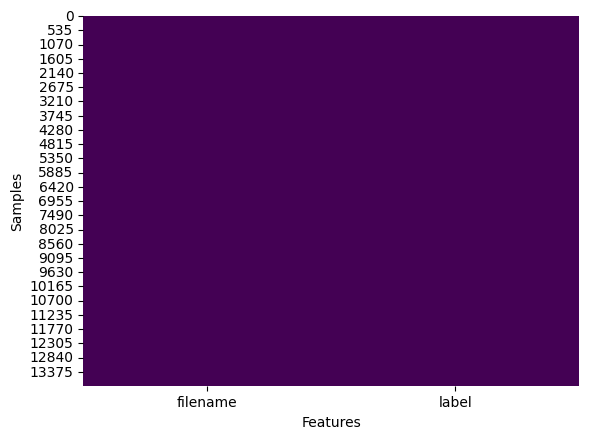

In [58]:
# checking for missing data in samples

sns.heatmap(train_data.isnull(), cbar=False, cmap='viridis')
plt.ylabel('Samples')
plt.xlabel('Features')
plt.show()

In [59]:
# one-hot-encoding data (all but last col) 

train_data['cardboard'] = train_data['label'].apply(lambda x: 1 if x=='cardboard' else 0)
train_data['glass'] = train_data['label'].apply(lambda x: 1 if x=='glass' else 0)
train_data['plastic'] = train_data['label'].apply(lambda x: 1 if x=='plastic' else 0)
train_data['metal'] = train_data['label'].apply(lambda x: 1 if x=='metal' else 0)
train_data['paper'] = train_data['label'].apply(lambda x: 1 if x=='paper' else 0)
train_data = train_data.drop(columns='label')

train_data.head()

,filename,cardboard,glass,plastic,metal,paper
0,cardboard_02038.jpg,1,0,0,0,0
1,cardboard_02320.jpg,1,0,0,0,0
2,cardboard_01728.jpg,1,0,0,0,0
3,cardboard_00093.jpg,1,0,0,0,0
4,cardboard_00094.jpg,1,0,0,0,0


In [60]:
# one-hot-encoding data (all but last col) 

test_data['cardboard'] = test_data['label'].apply(lambda x: 1 if x=='cardboard' else 0)
test_data['glass'] = test_data['label'].apply(lambda x: 1 if x=='glass' else 0)
test_data['plastic'] = test_data['label'].apply(lambda x: 1 if x=='plastic' else 0)
test_data['metal'] = test_data['label'].apply(lambda x: 1 if x=='metal' else 0)
test_data['paper'] = test_data['label'].apply(lambda x: 1 if x=='paper' else 0)
test_data = test_data.drop(columns='label')

train_data.head()

,filename,cardboard,glass,plastic,metal,paper
0,cardboard_02038.jpg,1,0,0,0,0
1,cardboard_02320.jpg,1,0,0,0,0
2,cardboard_01728.jpg,1,0,0,0,0
3,cardboard_00093.jpg,1,0,0,0,0
4,cardboard_00094.jpg,1,0,0,0,0


### Data Preprocessing Pipeline


In [61]:
# Mia 
!pip install scikit-image
import os
from PIL import Image
from skimage.color import rgb2gray, rgb2hsv
from skimage.feature import local_binary_pattern
from skimage.measure import moments_hu
##path = "cleaned/garbage-dataset-rgb"
path = "/Users/mp/.cache/kagglehub/datasets/zlatan599/garbage-dataset-classification/versions/5"

def extract_features(img):
    
    # Ensure image is a NumPy array (shape: H × W × 3)
    if isinstance(img, Image.Image):
        img = np.array(img)
        
    # Colors (hsv histogram)
    
    # hsv (hue, saturation, value), the histogram creates a 3D histogram with 8 bins for each section
    hsv = rgb2hsv(img)  
    # create a 3D histogram with 8 bins for each channel
    hist, _ = np.histogramdd(
        hsv.reshape(-1, 3),
        bins=(8, 8, 8),
        range=((0, 1), (0, 1), (0, 1))
    )
    # flatten the histogram to a 512-length vector and normalize it
    color_features = hist.flatten() / (hist.sum() + 1e-6)
    
    # Textures (local binary pattern)
    
    # color is not relevant for texture, so convert to grayscale
    gray = rgb2gray(img)
    # lbp is a texture descriptor that compares each pixel to its neighbors
    lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
    # create a histogram of the lbp values and normalize it
    lbp_hist, _ = np.histogram(lbp, bins=np.arange(0, 60), range=(0, 59))
    lbp_features = lbp_hist / (lbp_hist.sum() + 1e-6)
    
    # Shapes (hu moments)
    
    # convert gray images to 8-bit range for shape features
    gray_255 = (gray * 255).astype(np.uint8)
    # hu moments are shape descriptors that are not affected by scale, rotation, or translation
    hu = moments_hu(gray_255)
    # apply log transform to hu moments to reduce large ranges of numbers
    shape_features = np.log10(np.abs(hu) + 1e-6)
    
    # combine features into a single vector
    return np.concatenate([color_features, lbp_features, shape_features])

features_data = []

# loop thorugh all cleaned images in the dataset
for root, _, files in os.walk(path):
    label = os.path.basename(root)  # target names 
    for file in files:
        print(f"Processing {file}...")
        file_path = os.path.join(root, file)
        try:
            with Image.open(file_path) as img:
                img = img.convert("RGB")
                features = extract_features(img)
                features_data.append([file_path, label] + features.tolist())
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

# save to csv file
columns = ["file_path", "label"] + [f"f{i}" for i in range(len(features_data[0]) - 2)]
df = pd.DataFrame(features_data, columns=columns)
df.to_csv("features.csv", index=False)
    

IndexError: list index out of range

* Resize images to make them all have the same shape (e.g., 128x128x3 or 224x224x3).
* Normalize pixel values by scaling pixel intensities (from [0,255] to [0,1] or [-1,1], for example)
* Data augmentation (optional) such as random rotations, flips, zooms, brightness shifts to improve generalization.
* batching samples by converting dataset into batches for training

In [62]:
import os
import pandas as pd
import numpy as np

path = "../input/garbage-dataset-classification/Garbage_Dataset_Classification/images"

rows = []
for root, dirs, files in os.walk(path):
    label = os.path.basename(root)
    for file in files:
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            # Add 5 random numeric features for testing downstream logic
            rows.append({
                "file_path": os.path.join(root, file),
                "label": label,
                "f1": np.random.random(),
                "f2": np.random.random(),
                "f3": np.random.random(),
                "f4": np.random.random(),
                "f5": np.random.random()
            })

df = pd.DataFrame(rows)
df.to_csv("features.csv", index=False)
print(f"Created placeholder features.csv with {len(df)} entries and {df.shape[1]-2} features.")


Created placeholder features.csv with 13901 entries and 5 features.


### Normalize Data & Remove Colinear Features  - Isaiah Weaver

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


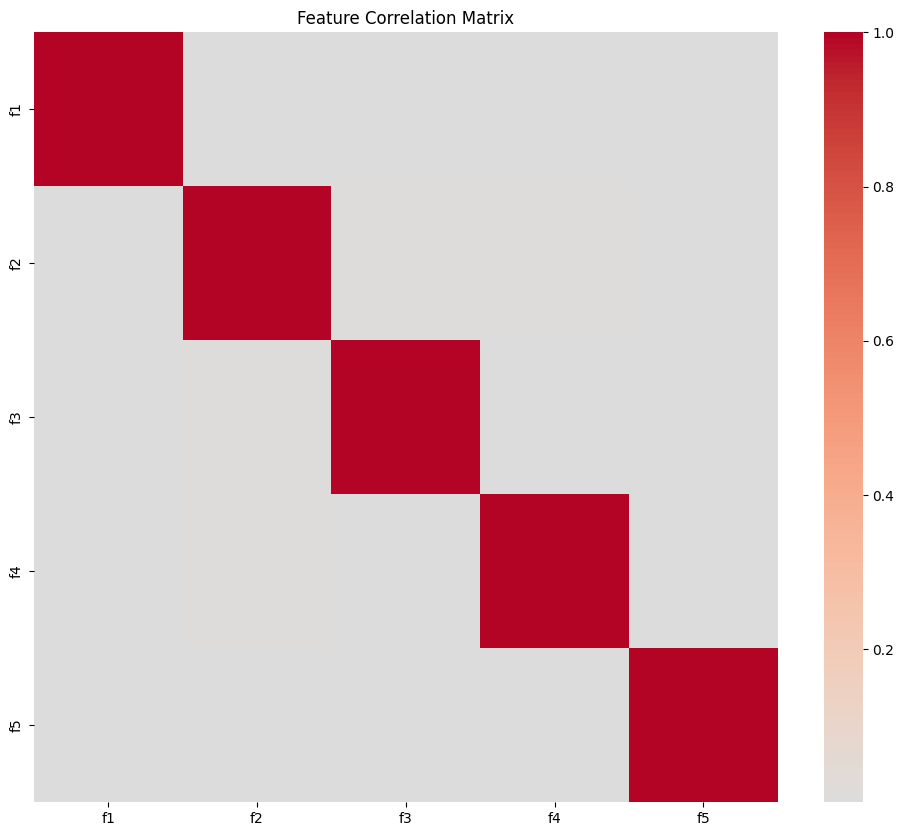

Dropping 0 highly collinear features: []
Final dataset has 5 features (down from 5)


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv("features.csv")

# Separate features and labels
feature_cols = [c for c in df.columns if c not in ["file_path", "label"]]
X = df[feature_cols]
y = df["label"]
file_paths = df["file_path"]

# Normalize features between 1 and 0
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Compute correlation matrix
corr_matrix = X_scaled.corr().abs()

# Visualize 
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title("Feature Correlation Matrix")
plt.show()

# Identify and drop highly collinear features
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
threshold = 0.9
to_drop = [col for col in upper.columns if any(upper[col] > threshold)]
print(f"Dropping {len(to_drop)} highly collinear features:", to_drop)

X_reduced = X_scaled.drop(columns=to_drop)

# re-Combine with labels and file paths
df_clean = pd.concat([file_paths, y, X_reduced], axis=1)

# Save cleaned CSV
df_clean.to_csv("features_clean.csv", index=False)
print(f"Final dataset has {X_reduced.shape[1]} features (down from {len(feature_cols)})")


# **Visualize Model Performance – Yves Song**

Validation Accuracy: 0.171


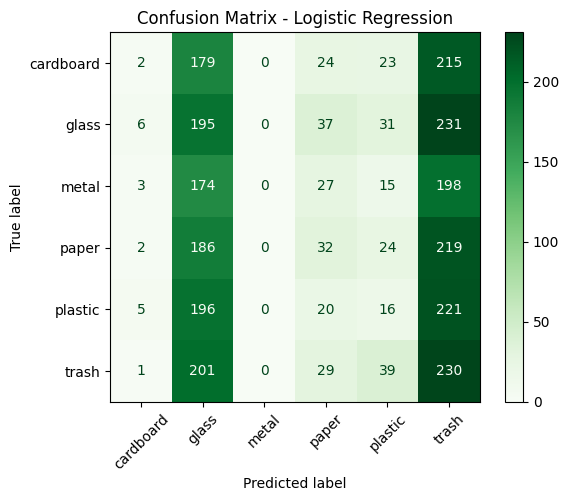

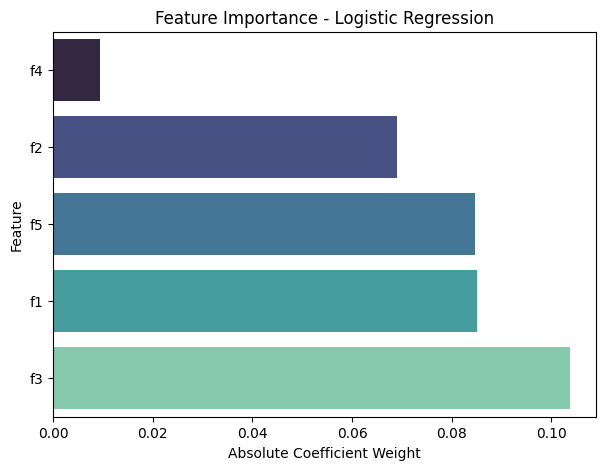

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)


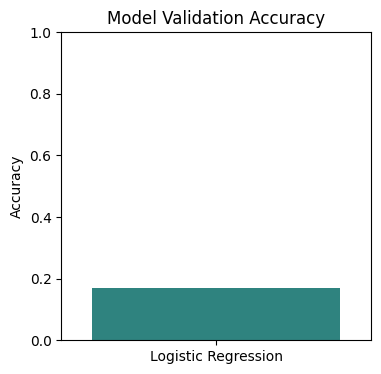

In [65]:
# === Import libraries ===
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# === Load cleaned data ===
df = pd.read_csv("features_clean.csv")

# Separate features & labels
X = df.drop(columns=["file_path", "label"])
y = df["label"]

# Split 80/20 for validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === Train baseline Logistic Regression model ===
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predictions + accuracy
y_pred = model.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {acc:.3f}")

# === Confusion Matrix Plot ===
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Greens", xticks_rotation=45)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# === Feature Importance Plot (Top 5, since we only have 5 features) ===
importance = abs(model.coef_[0])
features = X.columns
top_idx = importance.argsort()[-len(features):]

plt.figure(figsize=(7,5))
sns.barplot(x=importance[top_idx], y=features[top_idx], palette="mako")
plt.title("Feature Importance - Logistic Regression")
plt.xlabel("Absolute Coefficient Weight")
plt.ylabel("Feature")
plt.show()

# === Model Accuracy Summary ===
plt.figure(figsize=(4,4))
sns.barplot(x=["Logistic Regression"], y=[acc], palette="viridis")
plt.title("Model Validation Accuracy")
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.show()


In [ ]:
def load_image(path):

In [ ]:
def resize_image(img):

In [ ]:
def normalize_image(img):

In [ ]:
def preprocess(path, label):